In [ ]:
from mmmlu_preparer.read_mmmlu_dataset import (
    MMMLULanguage,
)
from mmmlu_preparer.query_formats import (

    ShuffleMethod,
)


model_list = ['gemini-2.0-flash', 'mistral-small-2503', 'llama-v3p1-8b-instruct']
lang_list = list(MMMLULanguage)
input_output_list = [('base', 'base'), ('base', 'json-full'), ('base', 'xml-full'),('json', 'base'),('json', 'json-full'),('json', 'xml-full'), ('xml', 'base'),('xml', 'json-full'),('xml', 'xml-full')]
shuffle_list = list(ShuffleMethod)

In [2]:
import pandas as pd
# From analysis
target_model_name = model_list[0]
test_df = pd.read_csv(f'{target_model_name}_merged_results.csv', engine='c')

In [3]:
import ast

def shuffle_map_type_conversion(shuffle_map):
    """Convert shuffled map string to python dictionary"""
    if isinstance(shuffle_map, str):
        return ast.literal_eval(shuffle_map)
    return shuffle_map

#test_df['Shuffled to Original']
test_df['Original to shuffled'] = test_df['Original to shuffled'].apply(shuffle_map_type_conversion)
test_df['Shuffled to Original']  = test_df['Original to shuffled'].apply(lambda x: {val:key for key, val in x.items()})

In [4]:
def map_answer(row):
    """Convert model's answer to the id in the default order"""
    response_ansewr = row['Response answer']
    shuffled_to_original = row['Shuffled to Original']
    if response_ansewr in shuffled_to_original:
        return shuffled_to_original[response_ansewr]
    return response_ansewr # nan

test_df['Response answer id in default'] = test_df.apply(map_answer, axis=1)

In [5]:
test_df['Format'] = test_df.apply(lambda x: f"{x['Input format']}_in_{x['Output format']}_out", axis=1)
invalid_answer_df = test_df[test_df['Response answer'] == 'Others']

In [6]:
lang_shuffle_invalid_df = invalid_answer_df.groupby(['Language', 'Shuffle method']).size().reset_index(name='count')

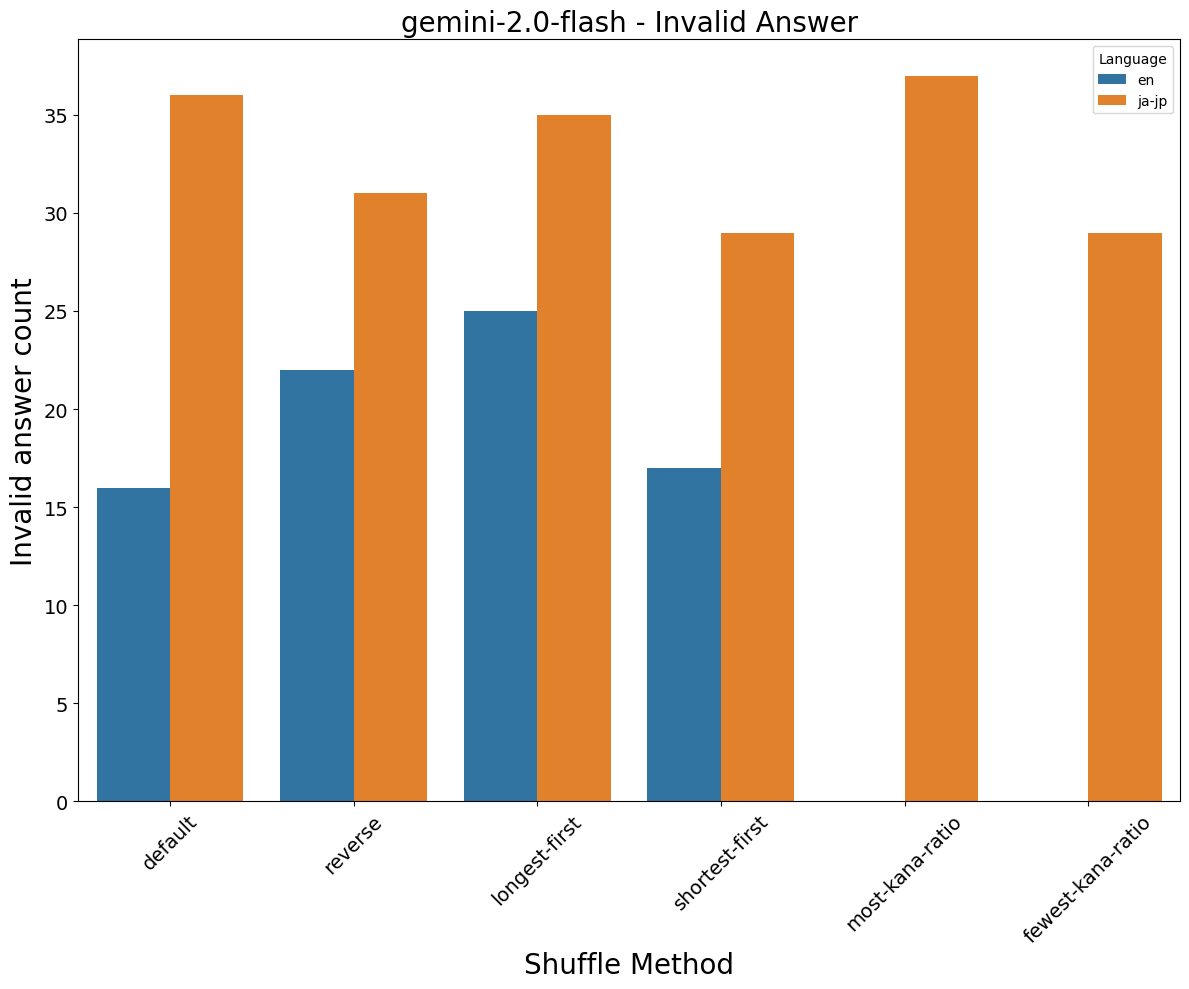

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# ChatGPT

lang_shuffle_invalid_df['Shuffle method'] = pd.Categorical(
        lang_shuffle_invalid_df['Shuffle method'],
        categories=[shuffle_enum.value for shuffle_enum in list(ShuffleMethod)],
        ordered=True
    )

plt.figure(figsize=(12, 10))
sns.barplot(data=lang_shuffle_invalid_df, x='Shuffle method', y='count', hue='Language')
plt.title(f'{target_model_name} - Invalid Answer', fontsize=20)
plt.xlabel('Shuffle Method', fontsize=20)
plt.ylabel('Invalid answer count', fontsize=20)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"./{target_model_name}_invalid.svg", format='svg')
plt.show()

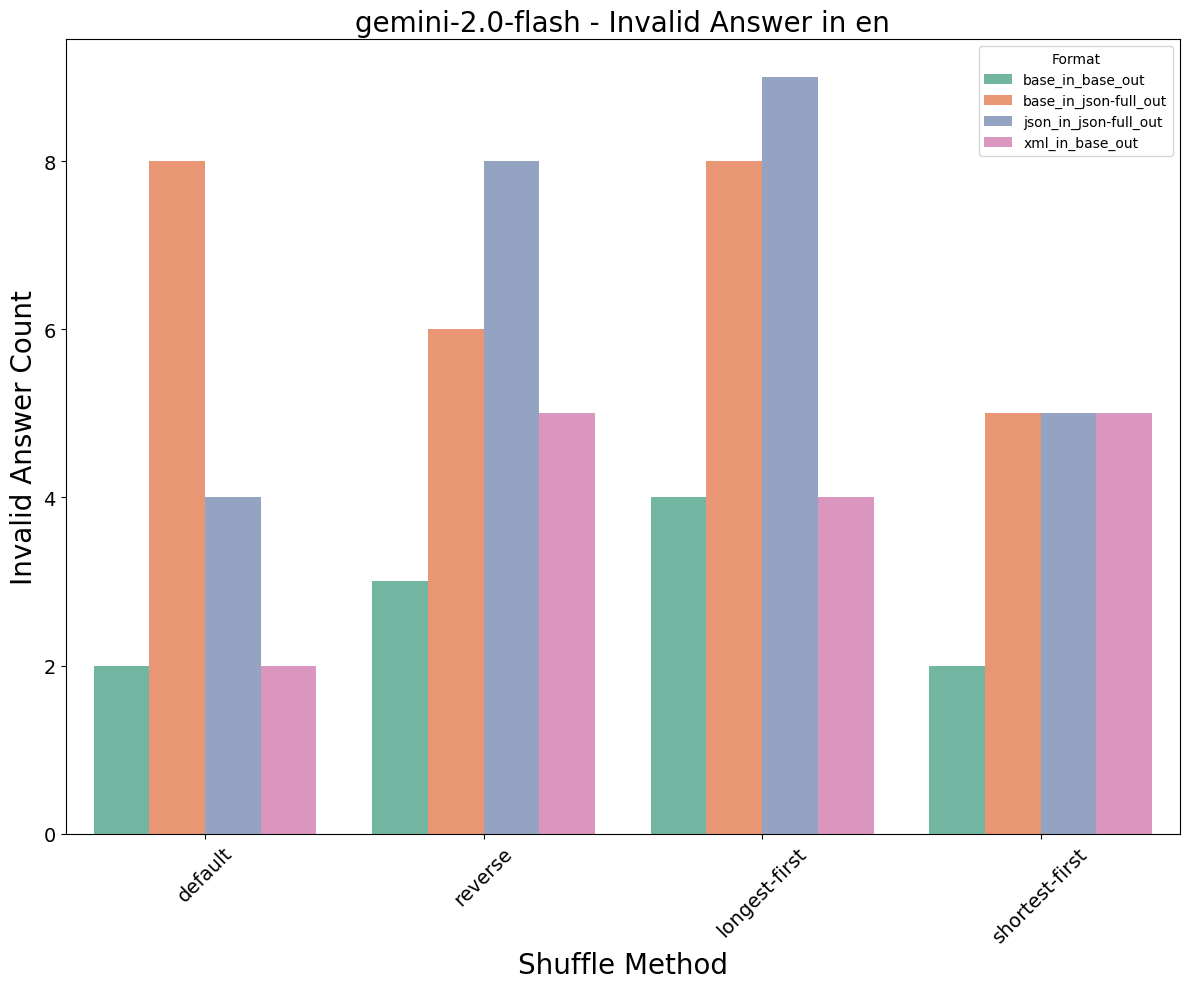

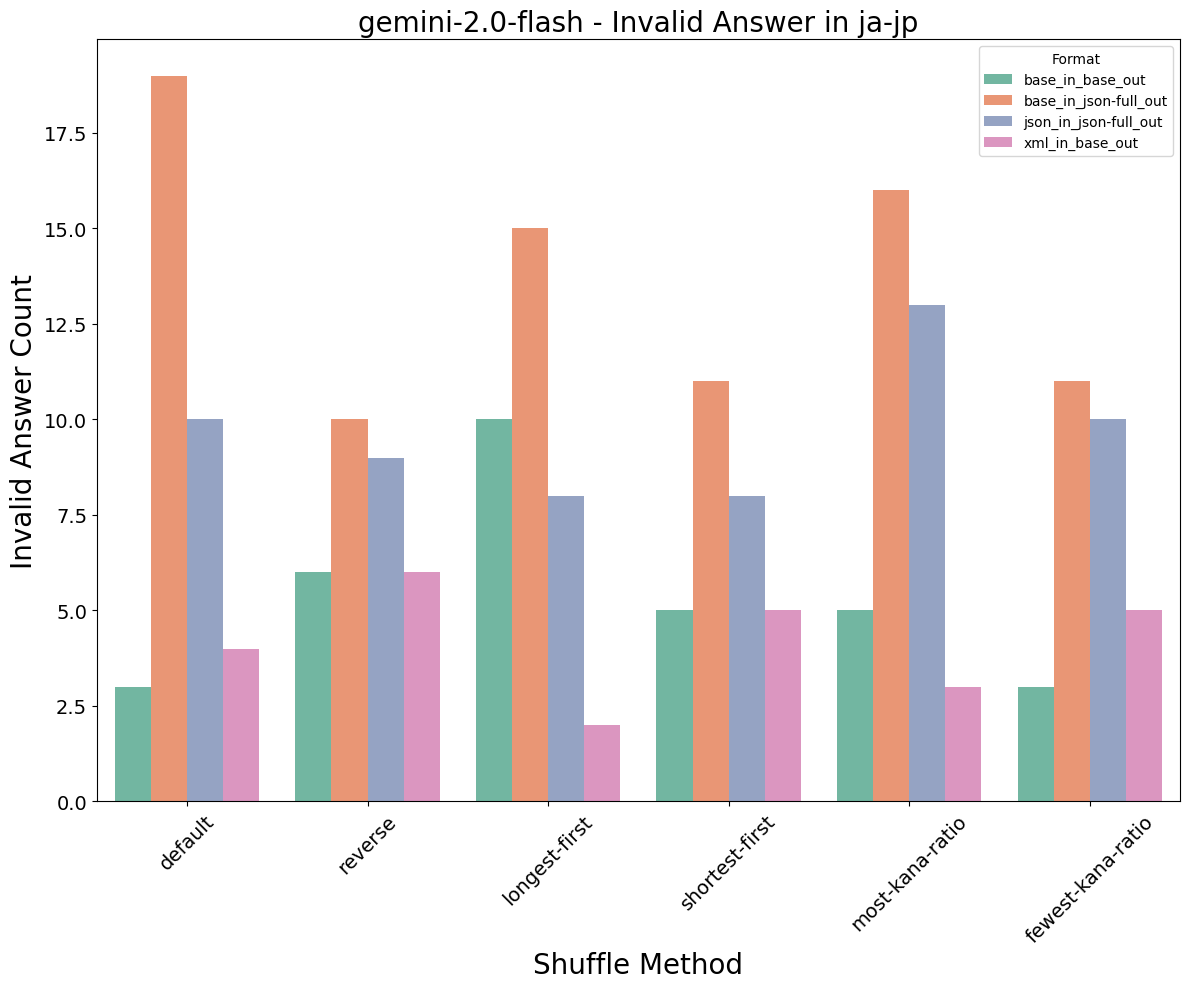

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ChatGPT
grouped = invalid_answer_df.groupby(['Language', 'Shuffle method', 'Format']).size().reset_index(name='count')
languages = grouped['Language'].unique()

for lang in languages:
    plt.figure(figsize=(12, 10))
    lang_df = grouped[grouped['Language'] == lang].copy()

    shuffle_method_list = [shuffle_enum.value for shuffle_enum in list(ShuffleMethod)]
    if lang != 'ja-jp':
        shuffle_method_list = shuffle_method_list[:-2]

    lang_df['Shuffle method'] = pd.Categorical(
        lang_df['Shuffle method'],
        categories=shuffle_method_list,
        ordered=True
    )

    sns.barplot(
        data=lang_df,
        x='Shuffle method',
        y='count',
        hue='Format',
        palette='Set2'
    )

    plt.title(f"{target_model_name} - Invalid Answer in {lang}", fontsize=20)
    plt.ylabel("Invalid Answer Count", fontsize=20)
    plt.xlabel("Shuffle Method", fontsize=20)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title='Format')
    plt.tight_layout()
    plt.savefig(f"./{target_model_name}_invalid_{lang}.svg", format='svg')
    plt.show()
